# Pothole Detection

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
%cd /content/drive/MyDrive/Project

/content/drive/MyDrive/Project


In [19]:
%ls

 BCCD_Dataset-master/   models/   RCNN/    roads_dataset/     test/
 model.png              New/      Roads/  'Roadss\model.h5'   Yolov5/


In [20]:
import tensorflow
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os


for dirname, _, filenames in os.walk(r'roads_dataset/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



roads_dataset/potholes/107.jpg
roads_dataset/potholes/101.jpg
roads_dataset/potholes/111.jpg
roads_dataset/potholes/12.jpg
roads_dataset/potholes/123.jpg
roads_dataset/potholes/116.jpg
roads_dataset/potholes/100.jpg
roads_dataset/potholes/109.jpg
roads_dataset/potholes/114.jpg
roads_dataset/potholes/122.jpg
roads_dataset/potholes/119.jpg
roads_dataset/potholes/115.jpg
roads_dataset/potholes/120.jpg
roads_dataset/potholes/110.jpg
roads_dataset/potholes/117.jpg
roads_dataset/potholes/103.jpg
roads_dataset/potholes/113.jpg
roads_dataset/potholes/105.jpg
roads_dataset/potholes/102.jpg
roads_dataset/potholes/104.jpg
roads_dataset/potholes/11.jpg
roads_dataset/potholes/108.jpg
roads_dataset/potholes/1.jpg
roads_dataset/potholes/118.jpg
roads_dataset/potholes/106.jpg
roads_dataset/potholes/112.jpg
roads_dataset/potholes/121.jpg
roads_dataset/potholes/10.jpg
roads_dataset/potholes/158.jpg
roads_dataset/potholes/125.jpg
roads_dataset/potholes/161.jpg
roads_dataset/potholes/150.jpg
roads_dataset

## Importing all the required libraries

In [21]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import InputLayer
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
import keras.preprocessing.image as img
from tensorflow.keras.applications.resnet50 import ResNet50

## Dataset is divided into two parts : test & train
### Both the directories (test and train) are divided further : Plain & Pothole

In [22]:
os.listdir('roads_dataset/')

['potholes', 'normal']

Resizing the images into (256 * 256) 

In [ ]:
def make_train_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        try:
            path = os.path.join(DIR,img)
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

            X.append(np.array(img))
            Z.append(str(label))
        except:
            pass
        
def assign_label(img,label):
    return label

In [24]:
X=[]
Z=[]
IMG_SIZE=256
Plain=r'roads_dataset/normal'
Pothole=r'roads_dataset/potholes'

make_train_data('Plain',Plain)
make_train_data('Pothole',Pothole)

100%|██████████| 329/329 [00:07<00:00, 41.99it/s]


## Displaying the training data with labels

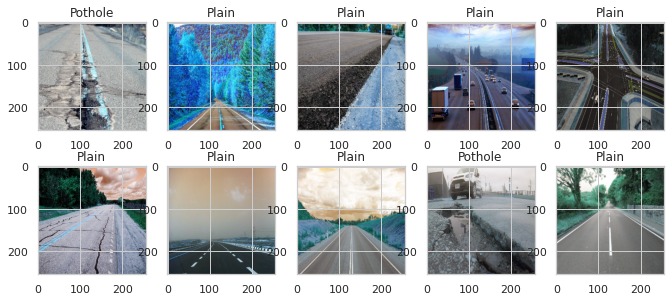

In [25]:
fig,ax=plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig.set_size_inches(10,10)

for i in range(2):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l][:])
        ax[i,j].set_title(Z[l])
        ax[i,j].set_aspect('equal')

## Splitting the data into Training and Validation data

In [26]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,2)
print(Y)
X=np.array(X)

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=1337)

np.random.seed(42)
rn.seed(42)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


# Building the CNN model using RESNET (pretrained model)

In [27]:
base_model=ResNet50(include_top=False, weights='imagenet',input_shape=(256,256,3), pooling='max')
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [28]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.20))
model.add(Dense(2048,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(2,activation='softmax'))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_5 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dense_7 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 30,408,066
Trainable params: 30,354,946


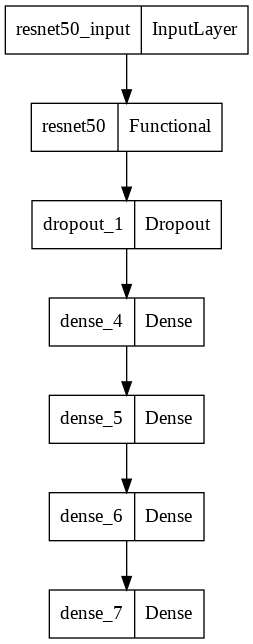

In [29]:
model.summary()
from tensorflow import keras
keras.utils.plot_model(model)

In [38]:
epochs=50
batch_size=128
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=2, verbose=1)
base_model.trainable=True # setting the VGG model to be trainable.
model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_5 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dense_7 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 30,408,066
Trainable params: 30,354,946


In [39]:
History = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test,y_test))

Epoch 1/50
16/16 [==============================] - 15s 517ms/step - loss: 0.0188 - accuracy: 0.9922 - val_loss: 0.1678 - val_accuracy: 0.9471
Epoch 2/50
16/16 [==============================] - 7s 462ms/step - loss: 0.0280 - accuracy: 0.9863 - val_loss: 0.0996 - val_accuracy: 0.9647
Epoch 3/50
16/16 [==============================] - 8s 473ms/step - loss: 0.0150 - accuracy: 0.9961 - val_loss: 0.0793 - val_accuracy: 0.9647
Epoch 4/50
16/16 [==============================] - 8s 476ms/step - loss: 0.0108 - accuracy: 0.9961 - val_loss: 0.0892 - val_accuracy: 0.9588
Epoch 5/50
16/16 [==============================] - 7s 471ms/step - loss: 0.0044 - accuracy: 0.9980 - val_loss: 0.0926 - val_accuracy: 0.9647
Epoch 6/50
16/16 [==============================] - 7s 463ms/step - loss: 0.0071 - accuracy: 0.9980 - val_loss: 0.0792 - val_accuracy: 0.9647
Epoch 7/50
16/16 [==============================] - 7s 460ms/step - loss: 8.9076e-04 - accuracy: 1.0000 - val_loss: 0.0765 - val_accuracy: 0.9647
E

## Saving the trained model

In [32]:
%ls

 BCCD_Dataset-master/   models/   RCNN/    roads_dataset/     test/
 model.png              New/      Roads/  'Roadss\model.h5'   Yolov5/


In [41]:
model.save('Roadss\model.h5')

## Model Accuracy

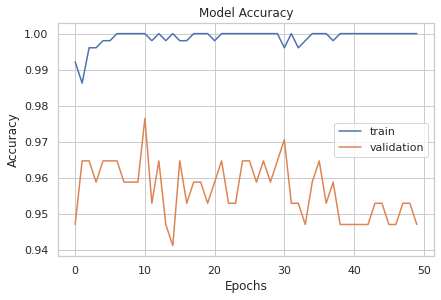

In [42]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## Model Loss

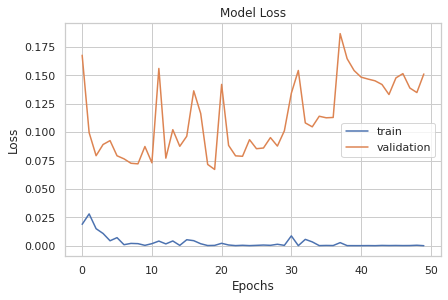

In [43]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy
# from sklearn import metrics



# confusion_matrix = metrics.confusion_matrix(y_test,)

# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

# cm_display.plot()
# plt.show()

# Testing the trained model 
### [0,1] --> Pothole road
### [1,0] --> Plain road

In [53]:
path = "roads_dataset/test/"
files = os.listdir(path)
files

ValueError: ignored

In [ ]:
for i in tqdm(y_test):
    pth = os.path.join(path,i)
    X = cv2.imread(pth,cv2.IMREAD_COLOR)
    X = cv2.resize(X,(256,256))
    plt.figure()
    plt.imshow(X[:,:,::-1]) 
    plt.show()  

    X = np.array(X)
    X = np.expand_dims(X, axis=0)

    y_pred = np.round(model.predict(X))
    if y_pred[0][0] == 1:
        print("Plain Road")
    else:
        print("Pot hole Road")

### Loading the model

In [56]:
History = tf.keras.models.load_model('/content/drive/MyDrive/Project/Roadss\model.h5')

In [57]:
score, acc = History.evaluate(x_test, y_test)
score, acc

6/6 [==============================] - 2s 116ms/step - loss: 0.1513 - accuracy: 0.9471


(0.15128719806671143, 0.9470587968826294)